**PREDIKSI STROKE**

Yang pertama dilakukan adalah menginstall module yang dibutuhkan untuk project ini.


1.   Kaggle untuk mendownload dataset stroke
2.   Imblearn untuk melakukan sampling jika data yang terdapat di dataset imbalanced.



In [1]:
 !pip install -q kaggle
 !pip install -q imblearn

Selanjutnya adalah mengimport library yang diperlukan

In [2]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler

Untuk mempercepat komputasi, saya menggunakan runtime GPU yang tersedia di google colab.

In [3]:
#mengecek versi tensorflow untuk memastikan dan GPU enabled untuk mempercepat training
print('Versi tensorflow yang dipakai adalah: ', tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Menggunakan GPU untuk training: ', device_name)

Versi tensorflow yang dipakai adalah:  2.18.0
Menggunakan GPU untuk training:  /device:GPU:0


Langkah selanjutnya adalah upload flie json kaggle yang berisi token untuk dapat mendownload dataset dari kaggle

In [4]:
#upload file json kaggle yang berisi token. Saya comment agar tidak terlihat tokennya
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arisdarmawan","key":"8c73639cf47659ce32ee2fc799d416fb"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Selanjutnya adalah mendownload dataset dari kaggle, di sini saya mendownload brain stroke dataset

In [6]:
!kaggle datasets download -d zzettrkalpakbal/full-filled-brain-stroke-dataset

Dataset URL: https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset
License(s): CC0-1.0
  0% 0.00/52.1k [00:00<?, ?B/s]
100% 52.1k/52.1k [00:00<00:00, 238MB/s]


In [7]:
! mkdir dataset
! unzip full-filled-brain-stroke-dataset.zip -d dataset

Archive:  full-filled-brain-stroke-dataset.zip
  inflating: dataset/full_data.csv   
  inflating: dataset/full_filled_stroke_data (1).csv  


Selanjutnya adalah membaca dataset dengan library pandas

In [8]:
dataset = pd.read_csv('/content/dataset/full_data.csv')

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


Dataset ini terdiri dari 11 kolom dan 4981 baris dengan rincian 5 kolom kategori object dan 6 kolom kategori numerikal. Terlihat bahwa datanya bersih karena tidak ada kolom yang berisi data yang kosong. Selanjutnya mari lihat 5 kolom teratas di dataset untuk melihat gambaran lebih jelas dari dataset ini.

In [10]:
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Keterangan dari masing-masing kolom berdasarkan informasi dari [website kaggle](https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset) adalah sebagai berikut :
* gender: "Male", "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heartdisease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* evermarried: "No" or "Yes"
* worktype: "children", "Govtjov", "Neverworked", "Private" or "Self-employed"
* Residencetype: "Rural" or "Urban"
* avgglucoselevel: average glucose level in blood
* bmi: body mass index
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* stroke: 1 if the patient had a stroke or 0 if not



**EXPLORATORY DATA ANALYSIS (EDA)**

Langkah pertama dari EDA adalah melihat informasi statistik kolom numerikal dengan fungsi describe.

In [11]:
dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


Kolom hypertension, heart disease, dan stroke datanya berisi 0 dan 1 saja, untuk kolom yang lain dapat disimpulkan datanya terdistribusi secara normal karena nilai rata-rata dan median datanya nyaris sama. Selanjutnya mari kita lihat apakah data ini balanced dengan melihat jumlah pasien yang stroke dan tidak

<Axes: xlabel='stroke', ylabel='count'>

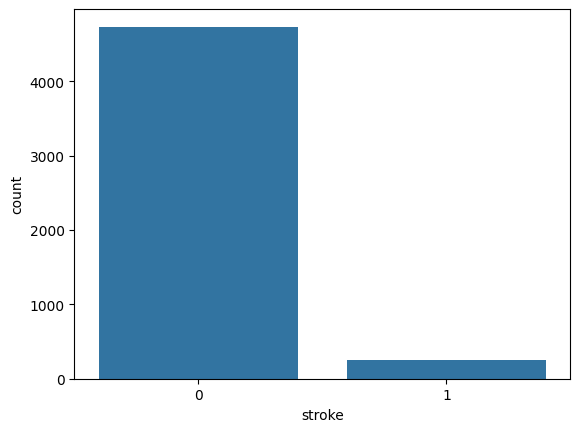

In [12]:
sns.countplot(data=dataset, x='stroke')

Terlihat bahwa dataset ini tidak balance karena perbandingan jumlah pasien yang stroke dan tidak sangat jauh sehingga kita harus hati-hati saat memodelkan dan menggunakan paramter metriks penilaian model ini. Selanjutnya mari kita lihat dari data pasien yang terkena stroke, pasien mana saja yang paling banyak terkena stroke

<Axes: xlabel='gender', ylabel='count'>

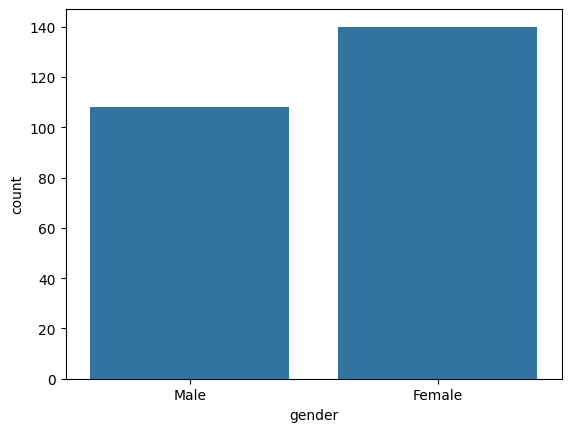

In [13]:
stroke = dataset[dataset['stroke']==1]
sns.countplot(data=stroke, x='gender')

Terlihat bahwa jumlah pasien wanita yang terkena stroke lebih banyak daripada pasien pria, namun perbandingannya tidak terlalu jauh.

<Axes: xlabel='work_type', ylabel='count'>

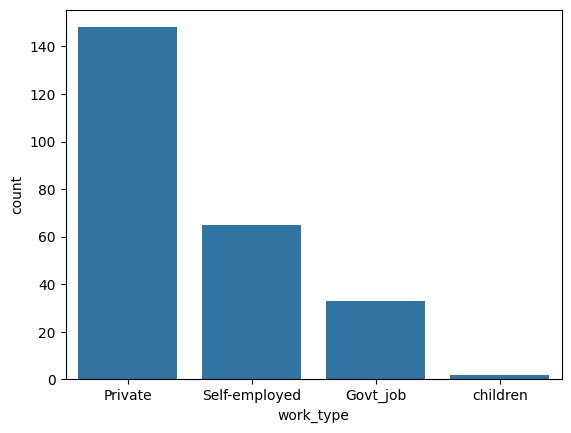

In [14]:
sns.countplot(data=stroke, x='work_type')

Berdasarkan chart di atas, terlihat bahwa pekerja di perusahaan swasta paling banyak terkena stroke disusul oleh pekerja wirausaha/freelance. Yang menarik adalah ada beberapa anak yang juga terkena stroke, untungnya jumlahnya sedikit.

<Axes: xlabel='smoking_status', ylabel='count'>

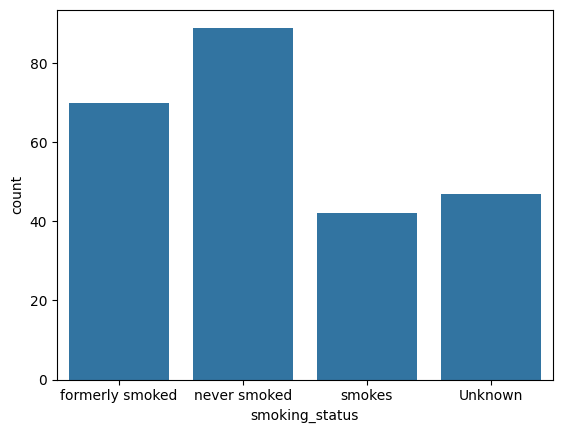

In [15]:
sns.countplot(data=stroke, x='smoking_status')

Terlihat bahwa orang yang belum pernah merokok paling banyak terkena stroke disusul oleh yang pernah merokok sebelumnya. Sedangkan jumlah perokok yang paling sedikit terkena stroke di data ini. Hmmm ternyata merokok tidak berpengaruh terhadap stroke ya..

<Axes: xlabel='Residence_type', ylabel='count'>

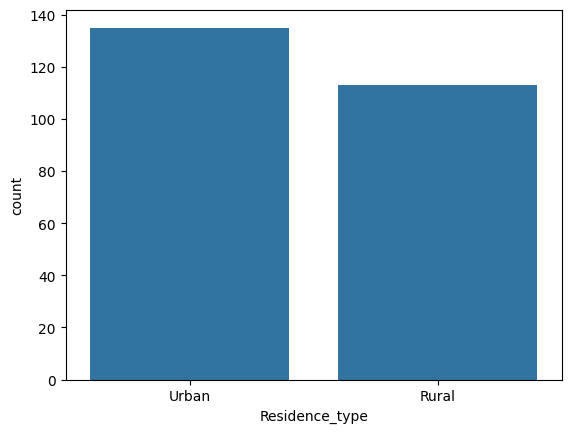

In [16]:
sns.countplot(data=stroke, x='Residence_type')

Terlihat bahwa pasien yang hidup di kota lebih banyak terkena stroke daripada yang hidup di daerah terpencil, namun perbedaan jumlahnya tidak signifikan.

<Axes: xlabel='ever_married', ylabel='count'>

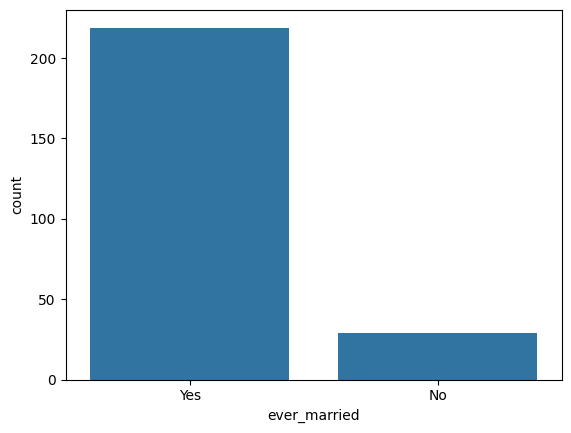

In [17]:
stroke = dataset[dataset['stroke']==1]
sns.countplot(data=stroke, x='ever_married')

Waw! ternyata ornag yang pernah menikah banyak terkena stroke dibanding orang yang belum menikah.. tapi kita buktikan dulu dengan data usianya ya... karena bisa jadi yang menikah ini sudah berumur haha

<Axes: xlabel='age', ylabel='Count'>

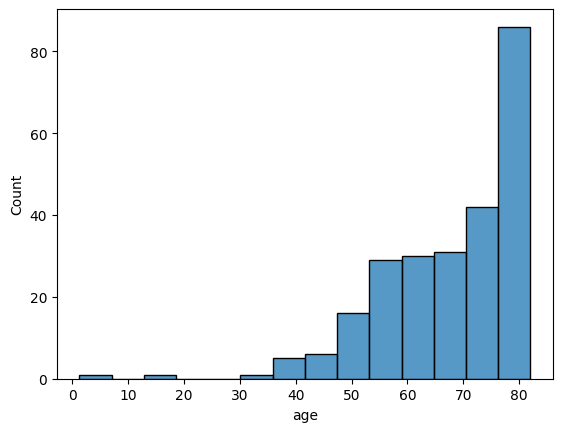

In [18]:
sns.histplot(data=stroke, x='age')

Berdasarkan histogram di atas.. terlihat bahwa mayoritas jumlah pasien yang terkena stroke adalah pasian yang sudah berumur 80 tahun. Sisanya kebanyakan di umur 50 tahun ke atas. Selanjutnya mari kita lihat korelasi antara kolom numerik di dataset ini.

<Axes: >

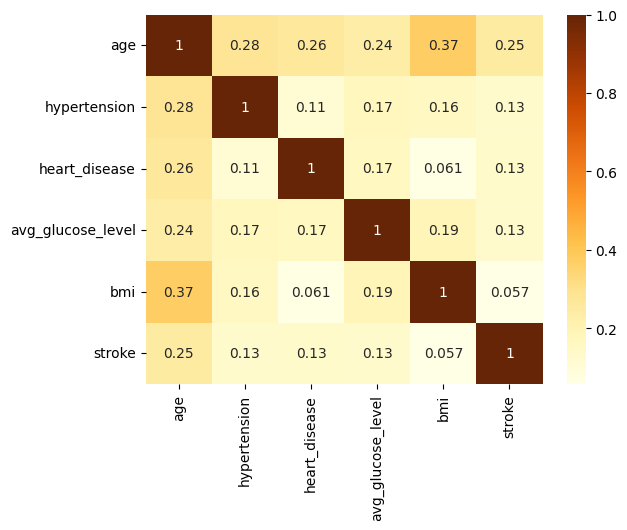

In [20]:
# Select only numeric columns for correlation calculation
numeric_dataset = dataset.select_dtypes(include=np.number)
sns.heatmap(numeric_dataset.corr(), annot=True, cmap='YlOrBr')

Terlihat bahwa kolom numerik di data ini berkolerasi rendah dengan kolom yang lain dengan kolom yang memiliki korelasi paling tinggi adalah kolom bmi dan umur dengan nilai 0,37. Dengan data yang seperti ini, kita tidak membutuhkan PCA karena korelasi antar kolomnya kecil sehingga tidak perlu ada kolom yang direduksi.

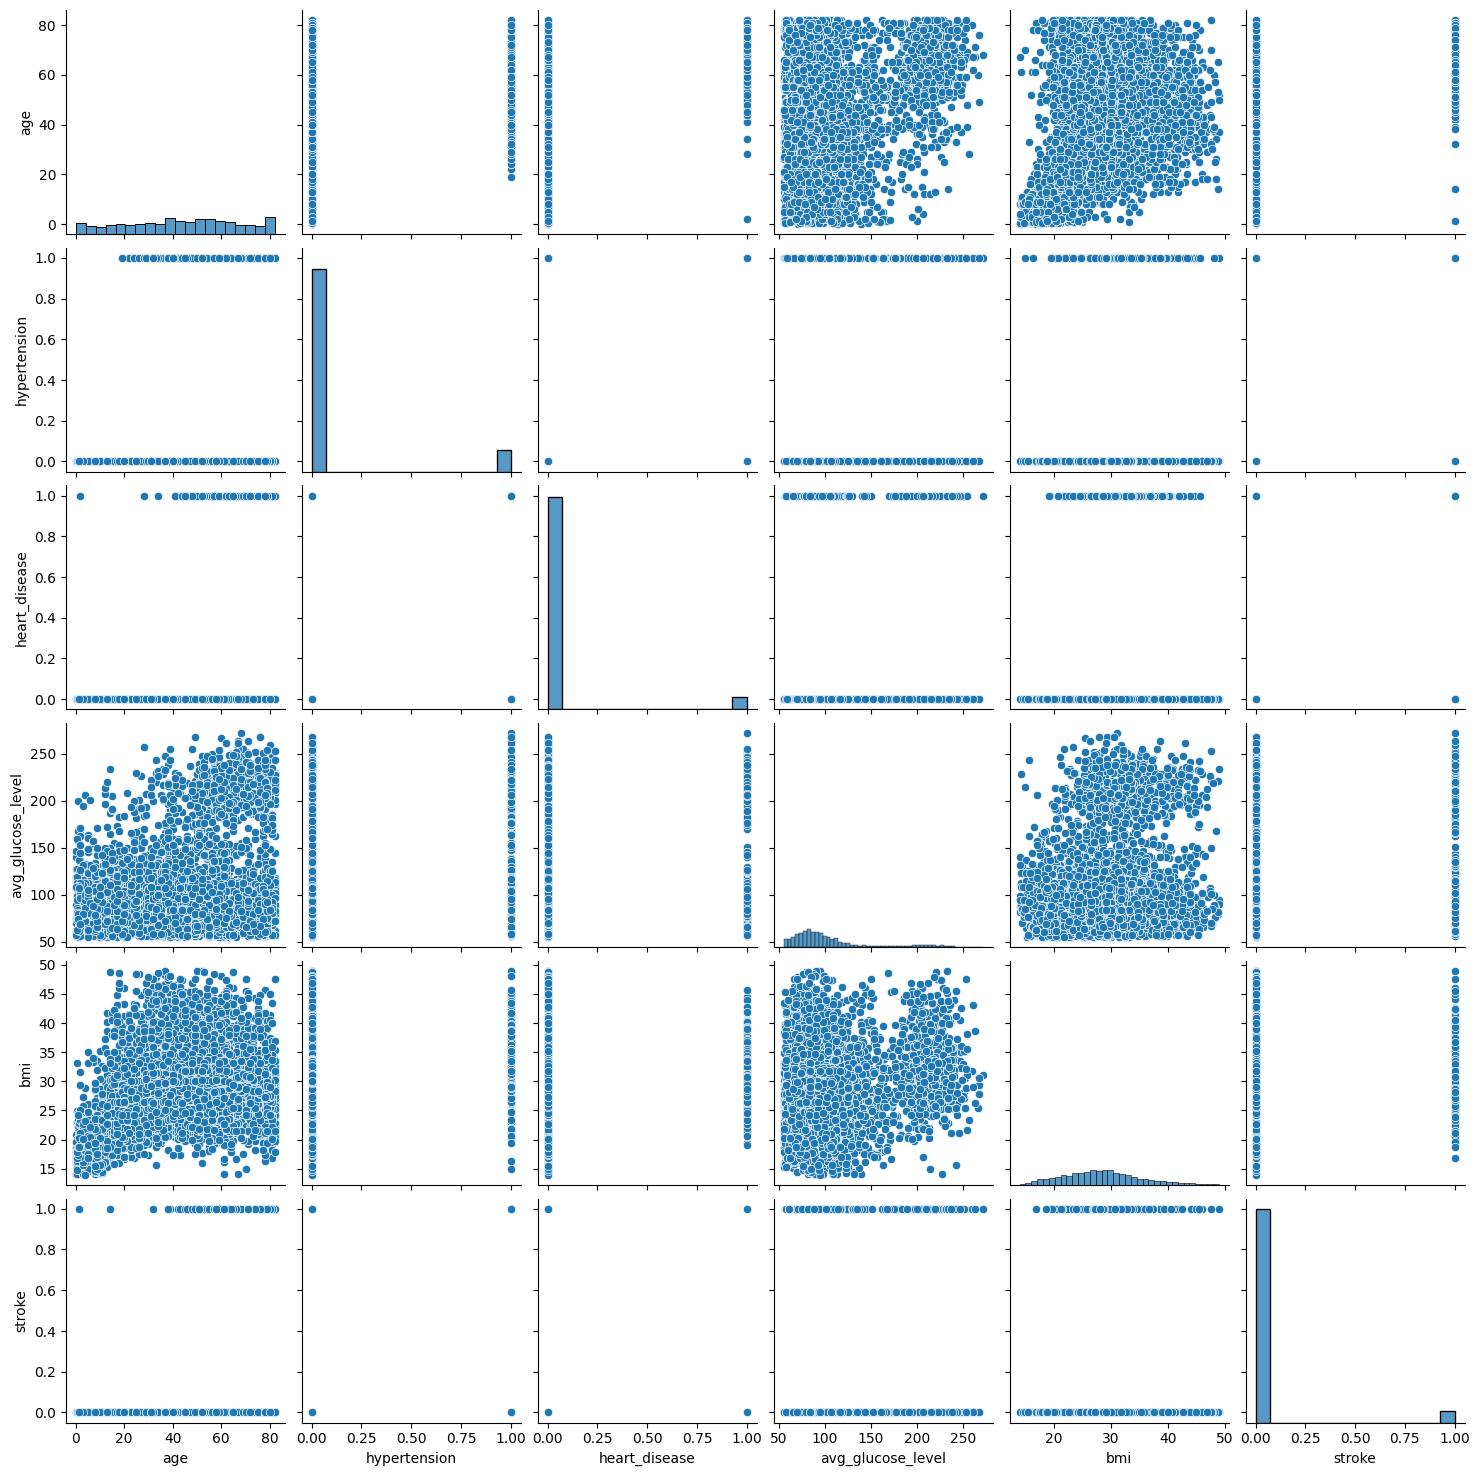

In [21]:
sns.pairplot(dataset)

Berdasarkan pairplot di atas juga menunjukkan bahwa korelasi antar kolomnya juga rendah dengan tidak ada kolom yang berkolerasi positif atau negatif

**FEATURE ENGINEERING**

Langkah selanjutnya sebelum membuat model adalah feature engineering. Pertama-tama, ubah dulu ya kolom yang kategori atau bukan numerik ke kolom numerik. Untuk kolom ever married dan gender sangat mudah mengubahnya karena isi di kolomnya hanya ada 2 kategori saja.

In [22]:
dataset['ever_married'] = [0 if i !='Yes' else 1 for i in dataset['ever_married']]
dataset['gender'] = [0 if i != 'Female' else 1 for i in dataset['gender']]

Untuk kolom sisanya saya menggunakan teknik one hot encoding dengan metode get_dummies yang sudah tersedia di library pandas

In [23]:
dataset = pd.get_dummies(dataset)

Mari kita lihat hasil akhir dari feature engineeringnya

In [24]:
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,228.69,36.6,1,False,True,False,False,False,True,False,True,False,False
1,0,80.0,0,1,1,105.92,32.5,1,False,True,False,False,True,False,False,False,True,False
2,1,49.0,0,0,1,171.23,34.4,1,False,True,False,False,False,True,False,False,False,True
3,1,79.0,1,0,1,174.12,24.0,1,False,False,True,False,True,False,False,False,True,False
4,0,81.0,0,0,1,186.21,29.0,1,False,True,False,False,False,True,False,True,False,False


Ya! datanya sudah siap untuk dibuat model machine learning

**SEPARATION OF TARGET AND FEATURES**

Langkah selanjutnya adalah memisahkan feature dan target dari dataset. Target dari dataset ini untuk diprediksi model adalah kolom stroke.

In [25]:
X = dataset.drop(['stroke'], axis = 1)
y = dataset['stroke']

Selanjutnya feature dan target saya pisah ke data trainging dan testing dengan ukuran 33% untuk data test. Mengapa? karena data testing ini penting untuk menilai performa model dalam memprediksi stroke, jika jumlahnya terlalu sedikit, kita tidak tahu performa model sebenarnya dalam memprediksi jumlah pasien yang akan sangat banyak.

In [26]:
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
X_train.shape, X_test.shape

((3337, 17), (1644, 17))

**MODEL BUILDING**

Nah, untuk memprediksi pasien yang stroke, saya menggunakan model random forest dan gradient boosting. Model yang sama-sama kumpulan dari decision tree namun berbeda dalam mengambil keputusan. Jika model random forest mengambil keputusan dengan cara "averaging" atau voting dari seluruh decision tree, gradient boosting mengambil keputusan melalui belajar dari kesalahan model yang "weak". Menurut pengalaman dan [referensi](https://www.baeldung.com/cs/gradient-boosting-trees-vs-random-forests#:~:text=Gradient%20boosting%20trees%20can%20be,and%20start%20modeling%20the%20noise.), harusnya gradient boosting bisa lebih bagus ya karena dia kan ada proses belajar dari kesalahan si "weak learner" itu.

In [27]:
rf = RandomForestClassifier(n_estimators=300,
                            criterion='gini',
                            max_depth=5,
                            n_jobs=-1,
                            random_state=0)

parameter yang dimasukkan dalam model adalah :
* n_estimators : menyatakan jumlah decision trees dalam model
* criterion : fungsi yang menentukan features di dataset untuk split percabangan membentuk decision trees. Di sini saya menggunakan gini impurity yaitu fungsi yang mengindikasikan kecenderungan data baru dan acak untuk salah dalam klasifikasi jika data tersebut diberikan label data secara acak berdasarkan distribusi kelas dalam dataset.
* max_depth : tingkat kedalaman decision trees
* n_jobs : jumlah proses yang dijalankan secara paralel. Saya pilih -1 untuk menggunakan semua thread processor
* random_state : status random pemilihan sampel saat membuat decision trees. Digunakan agar saat pengulangan nilainya sama.

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=300, n_jobs=-1, random_state=0)

In [29]:
rf_predict = rf.predict(X_test)

In [30]:
print(confusion_matrix(y_test,rf_predict))

[[1559    0]
 [  85    0]]


Berdasarkan confusion matrix terlihat bahwa model random forest memprediksi 85 false negative, artinya model menyatakan 85 pasien tidak terkena stroke padahal pasien tersebut seharusnya terkena stroke. Tentu saja hal itu sangat berbahaya

In [31]:
print(classification_report(y_test,rf_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1559
           1       0.00      0.00      0.00        85

    accuracy                           0.95      1644
   macro avg       0.47      0.50      0.49      1644
weighted avg       0.90      0.95      0.92      1644



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Meskipun akurasinya tinggi, tapi nilai precision, recall, dan f1-score nya rendah karena datasetnya imbalanced sehingga model kecenderungan memprediksi ke data yang dominan. Matriks pengukuran model yang saya gunakan adalah f1-score karena precision dan recall sama pentingnya untuk memprediksi stroke. Jangan sampai orang yang tidak stroke tapi diprediksi stroke karena bahaya jika minum obat penyakit stroke atau ditreatment stroke. Sebaliknya pun begitu, bahaya jika orang yang seharusnya stroke tapi malah diprediksi tidak kena stroke akhirnya dia tidak bisa dapat pengobatan. Nah, kalau precision dan recall sama pentingnya, maka matriks yang digunakan adalah f1-score karena f1-score adalah harmonic mean dari precision dan recall sesuai [referensi](https://stevkarta.medium.com/membicarakan-precision-recall-dan-f1-score-e96d81910354) berikut.

In [32]:
rf_f1 = f1_score(y_test, rf_predict)
print(rf_f1)

0.0


Terlihat bahwa f1-scorenya random forest rendah sekali meskipun nilai akurasinya tinggi.

In [33]:
gb = GradientBoostingClassifier(n_estimators=300,
                                max_depth=5,
                                random_state=0)

Model yang digunakan berikutnya adalah gradient boosting. Parameter yang dimasukkan dalam model adalah :
* n_estimators : menyatakan jumlah decision trees dalam model
* max_depth : tingkat kedalaman decision trees
* random_state : status random pemilihan sampel saat membuat decision trees. Digunakan agar saat pengulangan nilainya sama.

In [34]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=300, random_state=0)

In [35]:
gb_predict = gb.predict(X_test)

In [36]:
print(confusion_matrix(y_test,gb_predict))

[[1551    8]
 [  82    3]]


Gradient boosting memprediksi 8 false positive dan 82 false negative

In [37]:
print(classification_report(y_test,gb_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1559
           1       0.27      0.04      0.06        85

    accuracy                           0.95      1644
   macro avg       0.61      0.52      0.52      1644
weighted avg       0.91      0.95      0.92      1644



In [38]:
gb_f1 = f1_score(y_test, gb_predict)
print(gb_f1)

0.0625


Terlihat bahwa nilai f1-scorenya rendah meskipun nilai akurasinya tinggi. Hal ini dikarenakan dataset yang digunakan imbalance sehingga model cenderung memprediksi ke kelas yang dominan. Untuk mengatasi masalah data yang imbalance, dapat menggunakan teknik over-sampling atau under-sampling. Setiap teknik memiliki kelebihan dan kekurangan masing-masing. Salah satu kekurangan teknik over-sampling adalah adanya detail data yang hilang di kelas mayoritas karena dipilih beberapa sample saja. Di sini, saya memilih menggunakan teknik over-sampling di kelas yang minoritas (pasien stroke) sehingga tidak ada data yang hilang di kelas mayoritas (pasien non-stroke). Referensi dan informasi lebih detail tentang teknik sampling bisa dilihat di [sumber](https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/) berikut.

In [39]:
oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(X, y)
print(X_over.shape, y_over.shape)

(9466, 17) (9466,)


Jumlah data setelah dilakukan teknik oversampling menjadi 9466.

Selanjutnya, kita pisah lagi data yang sudah dioversampling ke data train dan test

In [40]:
X_train_rs, X_test_rs, y_train_rs , y_test_rs = train_test_split(X_over,y_over, test_size = 0.33, random_state = 43)
X_train_rs.shape, X_test_rs.shape

((6342, 17), (3124, 17))

Selanjutnya kita fit lagi data tersebut ke model random forest

In [41]:
rf.fit(X_train_rs, y_train_rs)

RandomForestClassifier(max_depth=5, n_estimators=300, n_jobs=-1, random_state=0)

In [42]:
rf_rs_predict = rf.predict(X_test_rs)

In [43]:
print(confusion_matrix(y_test_rs,rf_rs_predict))

[[1107  464]
 [ 156 1397]]


In [44]:
print(classification_report(y_test_rs,rf_rs_predict))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1571
           1       0.75      0.90      0.82      1553

    accuracy                           0.80      3124
   macro avg       0.81      0.80      0.80      3124
weighted avg       0.81      0.80      0.80      3124



In [45]:
rf_rs_f1 = f1_score(y_test_rs, rf_rs_predict)
print(rf_rs_f1)

0.8183948447568834


Terlihat bahwa setelah dilakukan oversampling nilai f1-score hasil prediksi menjadi jauh meningkat. Selanjutnya saya coba fit data tersebut ke model gradient boosting.

In [46]:
gb.fit(X_train_rs, y_train_rs)

GradientBoostingClassifier(max_depth=5, n_estimators=300, random_state=0)

In [47]:
gb_rs_predict = gb.predict(X_test_rs)

In [48]:
print(confusion_matrix(y_test_rs,gb_rs_predict))

[[1474   97]
 [   0 1553]]


Waw! Ternyata setelah dilakukan oversampling, model gradient boosting membuat hasil yang sangat bagus dengan tidak ada prediksi yang false negative. Artinya, model tersebut sudah memadai karena tidak ada pasien stroke yang diprediksi tidak stroke.

In [49]:
print(classification_report(y_test_rs,gb_rs_predict))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1571
           1       0.94      1.00      0.97      1553

    accuracy                           0.97      3124
   macro avg       0.97      0.97      0.97      3124
weighted avg       0.97      0.97      0.97      3124



In [50]:
gb_rs_f1 = f1_score(y_test_rs, gb_rs_predict)
print(gb_rs_f1)

0.9697158913518577


In [51]:
d = {'model':['Random Forest', 'Gradient Boosting'],
     'f1_score':[rf_rs_f1, gb_rs_f1]}
pd.DataFrame(data=d)

,model,f1_score
0,Random Forest,0.818395
1,Gradient Boosting,0.969716


Setelah dilakukan perbandingan, terlihat bahwa model dengan algoritma gradient boosting memiliki nilai f1-score yang lebih baik dari model random forest. Hal ini sesuai hipotesa di awal yang menyatakan bahwa model gradient boosting biasanya lebih baik dari model random forest.

Text(0.5, 1.0, 'Feature Importance of Gradient Boosting Model')

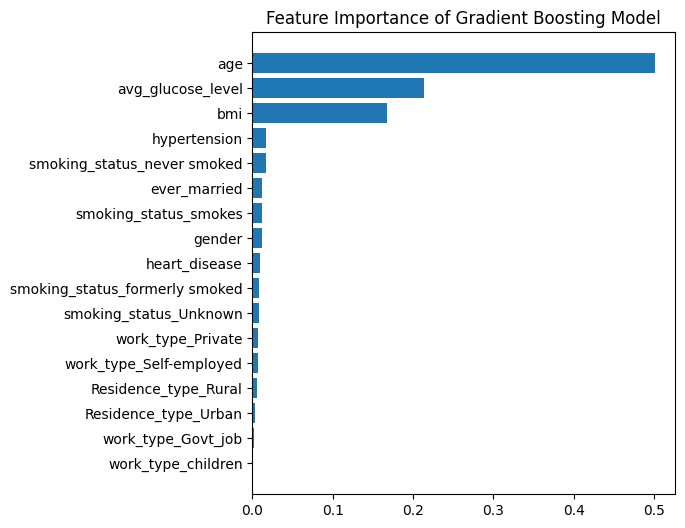

In [52]:
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dataset.drop('stroke', axis=1).columns)[sorted_idx])
plt.title('Feature Importance of Gradient Boosting Model')

Berdasarkan chart di atas, terlihat bahwa faktor yang paling berpengaruh terhadap prediksi stroke adalah umur, level gula darah, dan BMI (body mass index). Artinya kalau kita mau terhindar dari penyakit stroke kita harus jaga level gula darah dan BMI kita ya :)

In [53]:
import joblib

# Save the model to a file
filename = 'gradient_boosting_model.pkl'
joblib.dump(gb, filename)

print(f"Model saved to {filename}")

Model saved to gradient_boosting_model.pkl
